In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from dt_apriltags import Detector

In [3]:
class PID:
    def __init__(self, K_p=0.0, K_i=0.0, K_d=0.0, integral_limit=None):
        """Constructor
        Args:
            K_p (float): The proportional gain
            K_i (float): The integral gain
            K_d (float): The derivative gain
            integral_limit (float, optional): The integral limit
        """
        self.K_p = K_p
        self.K_i = K_i
        self.K_d = K_d
        self.integral_limit = integral_limit

        self.reset()

    def reset(self):
        """Reset the PID controller"""
        self.last_error = 0.0
        self.integral = 0.0
        self.last_time = time.time()

    def update(self, error, error_derivative=None):
        """Update the PID controller
        Args:
            error (float): The current error
        """
        current_time = time.time()
        dt = current_time - self.last_time

        if dt == 0:
            return 0.0

        self.last_time = current_time

        self.integral = self._get_integral(error, dt)
        if error_derivative is None:
            derivative = self._get_derivative(error, dt)
        else:
            derivative = error_derivative

        # TODO: Calculate the PID output
    

    
        output = self.K_p*error + self.K_i*self.integral + self.K_d*derivative

        self.last_error = error

        return output

    def _get_integral(self, error, dt):
        """Calculate the integral term
        Args:
            error (float): The current error
            dt (float): The time delta
        Returns:
            float: The integral term
        """

        # TODO: Calculate and return the integral term
         
        self.integral += error *dt
        if self.integral is not None:
            self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)
            return self.integral

        # Ki =1.0
        # error_accumulator = 0
        # error_accumulator += error * dt # dt is the time since the last update
        # integral = Ki * error_accumulator

        return self.integral

    def _get_derivative(self, error, dt):
        """Calculate the derivative term
        Args:
            error (float): The current error
            dt (float): The time delta
        Returns:
            float: The derivative term
        """

        # TODO: Calculate and return the derivative term
        #derivative = (error -self.last_error)/dt
        #self.last_error = error
        previous_error = self.last_error
        Kd = 1.0
        derivative = Kd * (error - previous_error) / dt # dt is the time since the last update
        previous_error = error

        return derivative


In [4]:
def frames(): 
    cap = cv2.VideoCapture('AprilTagTest.mkv')
    success = cap.grab()
    frames = []

    
    # slopes = []
    at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)
    cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))
    camera_params = (cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )
    i=0
    pidx = PID(30,0,0,100)
    pidy = PID(30,0,0,100)
    while success:
        if i % 100  == 0:
            _, frame = cap.retrieve()
            height, width, depth = frame.shape
            center = (width/2,height/2)
            print("Center of Video Frame:")
            print(center)
            cv2.line(frame, (int(width/2), 0), (int(width/2), int(height)), (255, 0, 0), 5)
            cv2.line(frame, (0,int(height/2)), (int(width), int(height/2)), (255, 0, 0), 5)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tags = at_detector.detect(frame, True, camera_params, 0.1)
            color_img = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
            for tag in tags:
                for idx in range(len(tag.corners)):
                    cv2.line(color_img, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))
                    print("Tag tuples of the coordinates:")
                    print(tuple(tag.corners[idx - 1, :].astype(int)) + tuple(tag.corners[idx, :].astype(int)))    
                    cv2.putText(color_img, str(tag.tag_id),
                    org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=2,
                    color=(0, 0, 255))
                (cX, cY) = (int(tag.center[0]), int(tag.center[1]))
                cv2.circle(color_img, (cX, cY), 5, (0, 0, 255), -1)
                dist = (cX-center[0],cY-center[1])
                print("PID (X, Y):")
                print(dist[0],dist[1])
                cv2.putText(frame, str((cX, cY)))
            
            pidx.update(dist[0])
            pidy.update(dist[1])
                # dist = np.sqrt(np.power(cX-center[0],2)+np.power(cY-center[1],2))
                # print((cX-center[0],cY-center[1]),dist)
            plt.imshow(color_img)
            plt.pause(0.01)  # Pause for a short time to show the figure
            plt.clf()
        i+=1
        success = cap.grab()


# Release the video capture
    cap.release()

# Close the plot window
plt.close()


Center of Video Frame:
(960.0, 540.0)
Tag tuples of the coordinates:
(1198, 223, 1002, 218)
Tag tuples of the coordinates:
(1002, 218, 993, 410)
Tag tuples of the coordinates:
(993, 410, 1192, 417)
Tag tuples of the coordinates:
(1192, 417, 1198, 223)
PID (X, Y):
136.0 -224.0


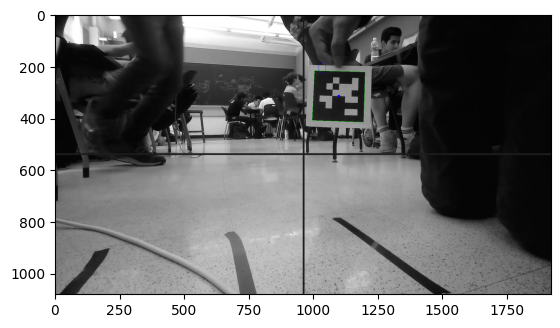

Center of Video Frame:
(960.0, 540.0)
Tag tuples of the coordinates:
(1236, 342, 1047, 310)
Tag tuples of the coordinates:
(1047, 310, 1012, 504)
Tag tuples of the coordinates:
(1012, 504, 1200, 536)
Tag tuples of the coordinates:
(1200, 536, 1236, 342)
PID (X, Y):
164.0 -117.0


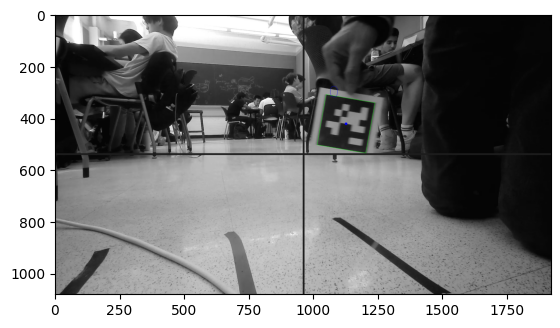

Center of Video Frame:
(960.0, 540.0)
Tag tuples of the coordinates:
(925, 192, 784, 154)
Tag tuples of the coordinates:
(784, 154, 759, 293)
Tag tuples of the coordinates:
(759, 293, 893, 329)
Tag tuples of the coordinates:
(893, 329, 925, 192)
PID (X, Y):
-120.0 -296.0


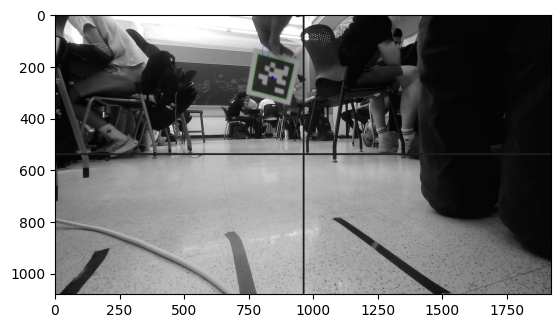

Center of Video Frame:
(960.0, 540.0)


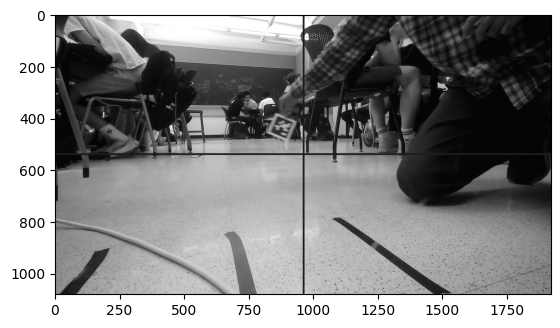

Center of Video Frame:
(960.0, 540.0)


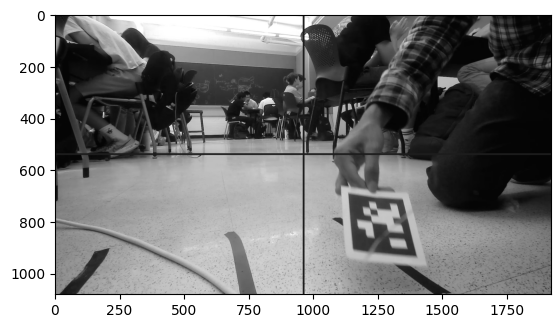

Center of Video Frame:
(960.0, 540.0)
Tag tuples of the coordinates:
(1265, 848, 1109, 860)
Tag tuples of the coordinates:
(1109, 860, 1170, 942)
Tag tuples of the coordinates:
(1170, 942, 1354, 918)
Tag tuples of the coordinates:
(1354, 918, 1265, 848)
PID (X, Y):
265.0 348.0


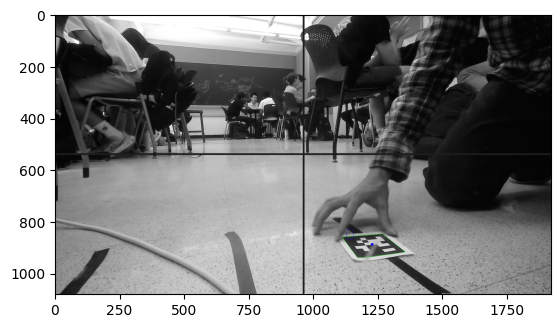

Center of Video Frame:
(960.0, 540.0)


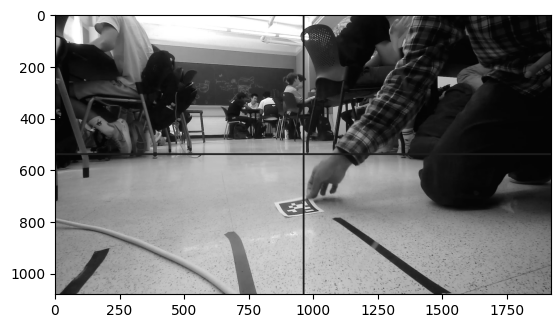

Center of Video Frame:
(960.0, 540.0)


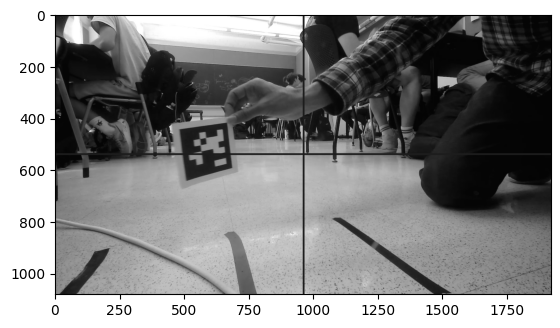

Center of Video Frame:
(960.0, 540.0)
Tag tuples of the coordinates:
(1247, 283, 1084, 295)
Tag tuples of the coordinates:
(1084, 295, 1099, 461)
Tag tuples of the coordinates:
(1099, 461, 1263, 446)
Tag tuples of the coordinates:
(1263, 446, 1247, 283)
PID (X, Y):
214.0 -170.0


In [5]:
frames = frames()
height, width, layers = frames[0].shape